<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM_w2v_oct_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar bibliotecas y Embeddings preentrenados y Capa de Atención

In [ ]:
# Usaremos la versión previa(2.5.0) de tensoflow para poder utilizar la capa de atención.
!pip install tensorflow==2.5.0

In [ ]:
# Mecanismo de Atención  
!wget -c "https://raw.githubusercontent.com/madhav727/abstractive-news-summary/master/attention.py"

In [ ]:
!pip install contractions

In [ ]:
!pip install Rouge

<h3>Bibliotecas<h3>

In [ ]:
import pandas as pd
import numpy as np

import gensim
#from gensim.models import KeyedVectors
import contractions
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset  # Convierte conjuntos de datos de Python a tensores
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  # Crear diccionario para convertir palabras a indices y vs.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Rellenar con cero los vectores de las secuencias hasta la longitud máxima
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate #, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from attention import AttentionLayer  # Mecanismo de atención tomado de: https://github.com/madhav727/abstractive-news-summary

from rouge import Rouge   #Evaluación 

import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.5.0'

<h3>Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés


Referencia uso word embedings preentrenados con Keras en este [enlace](https://keras.io/examples/nlp/pretrained_word_embeddings/)


In [ ]:
#!wget wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!gunzip /content/GoogleNews-vectors-negative300.bin.gz -d /content/drive/MyDrive/Datos/Embeddings/

In [ ]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datos/Embeddings/GoogleNews-vectors-negative300.bin',
                                                        binary=True)

In [ ]:
print('Palabras en el modelo w2v: {:,} '.format(len(w2v.vocab)))
print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


In [ ]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 6.01 s, sys: 214 ms, total: 6.23 s
Wall time: 6.26 s


# Funciones

In [ ]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [ ]:
def Vectorizer(serie_pd, max_tokens= 20000):
    '''Crear diccionario para convertir palabras en índices '''
    text_ds = Dataset.from_tensor_slices(serie_pd).batch(128)  # transforma la serie a tensores
    vectorizer = TextVectorization(max_tokens = max_tokens  )  
    vectorizer.adapt(text_ds)   #similar a fit 
    return  vectorizer

In [ ]:
def vectores_palabras(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    '''Obtiene una matriz donde cada renglón es el 'embedding vector' de una 
    palabra del vocabulario '''
    num_tokens = len(dic_vocabulario.keys()) 
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # los vectores no encontrados en el embeding se quedan en cero
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [ ]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  palabras_indices_reseña_sum['tokenstart']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Escoje la próxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = indices_palabras_resumen[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+ sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_titulos-1))):
                stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    '''obtiene el resumen, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if((i != 0 and i != palabras_indices_reseña_sum['tokenstart']) and i != palabras_indices_reseña_sum['tokenend']):
        newString = newString + indices_palabras_resumen[i]+' '
    return newString

def seq2text(input_seq):
    '''obtiene la reseña, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + indices_palabras_reseña[i]+' '
    return newString

# Lectura de Datos y preparación de secuencias

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=10000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(9519, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 6521
Makes strong Tea
This tea makes extremely dark and strong tea on the 11oz setting which is my largest water capacity setting. I use the Keurig Iced Beverage Tumblers filled with ice and can't drink it straight.  My solution is to fill a gallon pitcher with ice, add some water, make two iced brew K-cups and pour it over the ice water for what I consider perfect iced tea.  You can forego the water for stronger tea, or add more water to dilute the tea depending on your mood or tastes.  This tea has excellent flavor, it's just too strong right out of the Keurig for my tastes and in my opinion requires diluting.  Excellent for making a pitcher of tea!

Review # 671
That's a spicy!
If you've tried the conventional Kettle crinkle chip verson Salt and Peper, you CAN'T compare these to those!  These are easily some of the most spicy chips you will ever eat, but oompletely enjoyable.  You finish the bag and the indside is just coated with spices.  Great stuff.

Review # 5309
My do

## Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [ ]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)

CPU times: user 620 ms, sys: 4.95 ms, total: 625 ms
Wall time: 628 ms


## Agregar token que identifique el inicio y el final de la secuencia objetivo (resúmenes).

In [ ]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [ ]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 3055
tokenstart now this is pasta  tokenend
i ordered this pasta because i thought my children would love the animal shapes since i am the only glutenfree in our home i try to find fun things for the entire family instead of making 2 separate meals when i served this at dinner the other night my husband s expression said it all he followed his surprised look with now this is pasta we could not believe how good this pasta was we are now hooked i can not wait to try some more of the orgran products 

Review # 1174
tokenstart made in china tokenend
i purchased these to give to children who come to my place of business when they arrived it says clearly on the back of the individual wrapper made in china no way i am giving these to children if they were manufactured in china following the whole poisoned pet food debacle the fact that these are made in china needs to be highlighted much more clearly 

Review # 6152
tokenstart delicious tokenend
this was a gift from my lil sis aweso

## Fijar longitud máxima de palabras en textos y resumenes

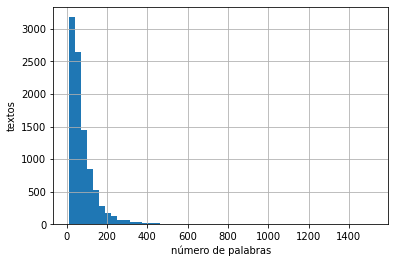


El 90% de los textos tiene 154 palabras


In [ ]:
# ¿Cuantas palabras tienen cada texto?
palabras_textos = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_textos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_textos.quantile(0.90)))

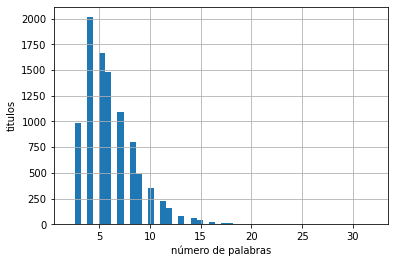


El 97.5% de los titulos tiene 13 palabras


In [ ]:
# ¿Cuantas palabras tienen cada titulo?
palabras_titulos = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_titulos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("titulos")
plt.show()

print('\nEl 97.5% de los titulos tiene {:,.0f} palabras'.format(palabras_titulos.quantile(0.975)))

In [ ]:
longitud_max_textos = palabras_textos.quantile(0.90)     #168 palabras
longitud_max_titulos = palabras_titulos.quantile(0.975)  # 13 palabras

In [ ]:
datos =  df[(palabras_textos <= longitud_max_textos ) & (palabras_titulos <= longitud_max_titulos)]
datos.shape   

(8466, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)
print('{} reseñas en el conjunto de entrenamiento\n{} reseñas en el conjunto de prueba'.format(len(x_train), len(x_test)))

7619 reseñas en el conjunto de entrenamiento
847 reseñas en el conjunto de prueba


# Preparar las secuencias para ingresar al modelo

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


### 1)  Crear diccionario para convertir palabras en índices (en el entrenamiento) y otro para regresar índices a palabras (durante la predicción)

In [ ]:
%%time
vectorizer_reseña = Vectorizer(x_train)

# Diccionarios de la secuencia de entrada
voc_reseña = vectorizer_reseña.get_vocabulary()  # lista con el vocabulario
palabras_indices_reseña = dict(zip(voc_reseña, range(len(voc_reseña))))
indices_palabras_reseña = dict(map(reversed, palabras_indices_reseña.items()))

CPU times: user 456 ms, sys: 34.5 ms, total: 490 ms
Wall time: 539 ms


In [ ]:
palabras_indices_reseña.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'this', 'of', 'not', 'for', 'in', 'my', 'have', 'that', 'are', 'but', 'you', 'with', 'was', 'they', 'like', 'these', 'as', 'on', 'so', 'good', 'them', 'great', 'coffee', 'taste', 'will', 'very', 'product', 'just', 'be', 'flavor', 'at', 'one', 'would', 'all', 'or', 'do', 'if', 'we', 'am', 'love', 'can', 'has', 'from', 'had', 'more', 'when', 'me', 's', 'than', 'really', 'no', 'other', 'out', 'tea', 'some', 'amazon', 'only', 'were', 'too', 'best', 'get', 'much', 'use', 'food', 'tried', 'because', 'up', 'little', 'about', 'buy', 'time', 'price', 'there', 'better', 'find', 'an', 'also', 'what', 'make', 'did', 'chips', 'try', 'well', 'cup', 'your', 'been', 'again', 'chocolate', 'does', 'even', 'drink', 'any', 'which', 'hot', 'he', 'after', 'by', 'now', 'mix', 'sugar', 'bought', 'water', 'made', 'could', 'she', 'eat', 'our', 'found', 'first', 'sweet', 'recommend', 'free', 'bag', 'used', 'favorite', '2', 'order', 'delicious', 'c

[UNK] es un token especial que se usara cuando se encuentren palabras que no están en el vocabulario.

In [ ]:
vectorizer_resumen = Vectorizer(y_train)
# Diccionarios de la secuencia de entrada
voc_resumen = vectorizer_resumen.get_vocabulary()  # lista con el vocabulario
palabras_indices_resumen = dict(zip(voc_resumen, range(len(voc_resumen))))
indices_palabras_resumen = dict(map(reversed, palabras_indices_resumen.items()))


In [ ]:
ejemplos = x_train.iloc[:2]
for ej in ejemplos:
  print(len(ej.split()))
  print(ej)

73
fantastic product keeps fresh for months had a bag in my desk that i had opened but packet was resealed product still fresh after several weeks product has a spicy but not hot flavor and is enjoyed by my whole family i am diabetic and have a hard time finding low sodium low calorie snacks grandpa po s products are both low sodium low calorie and also taste great i would highly recommend 
98
these creamers come in 4 packs of 25 i have taken one to work and opened one for home so far and have not found a single broken or leaking creamer yet i usually have way too much cream and sugar in my coffee but with these it is easy for me to cut down on the sweetness because i will not allow myself more than 2 creamers per cup i think this is definitely the best option for buying creamers from amazon since all the other listings have a lot of complaints about creamers breaking in shipping 


In [ ]:
ejemplos_vec = ejemplos.apply(vectorizer_reseña)
for ej in ejemplos_vec:
  print(len(ej))
  print(ej)

73
tf.Tensor(
[ 574   35  907  176   12  409   52    5  121   13   14 2594   16    3
   52  496   18  832   21 9450   35  142  176  104  311  591   35   50
    5  374   18   11  102   38    4    8  462  105   14  207  242    3
   47 1771    4   15    5  205   79  720  296  649  296  476  582 2049
 1939   56  223   17  235  296  649  296  476    4   85   32   30    3
   41  221  119], shape=(73,), dtype=int64)
98
tf.Tensor(
[  24 3766  357   13  193  678   10  863    3   15 1618   40    7  198
    4  496   40   12  317   27  218    4   15   11  116    5  529  801
   43 3354 1362  427    3  306   15  134   67   70  391    4  108   13
   14   31   18   20   24    6    8  148   12   55    7  590  259   26
    2  694   74    3   33   11 1788  469   53   57  124 3766  302   92
    3  143    9    8  184    2   68  696   12  212 3766   51   64  147
   42    2   60 5429   15    5  170   10 1775   77 3766 1982   13  200], shape=(98,), dtype=int64)


In [ ]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_resumen)
y_test_vec = y_test.apply(vectorizer_resumen)

CPU times: user 44 s, sys: 441 ms, total: 44.4 s
Wall time: 44.4 s


## 2) Rellenar cada secuencia hasta alcanzar la longitud máxima

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

ejemplos_seq =  pad_sequences(ejemplos_vec, maxlen = int(longitud_max_textos), padding='post')
for ej in ejemplos_seq:
  print(len(ej))
  print(ej)

154
[ 574   35  907  176   12  409   52    5  121   13   14 2594   16    3
   52  496   18  832   21 9450   35  142  176  104  311  591   35   50
    5  374   18   11  102   38    4    8  462  105   14  207  242    3
   47 1771    4   15    5  205   79  720  296  649  296  476  582 2049
 1939   56  223   17  235  296  649  296  476    4   85   32   30    3
   41  221  119    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
154
[  24 3766  357   13  193  678   10  863    3   15 1618   40    7  198
    4  496   40   12  317   27  218    4   15   11  116    5  529  801
   43 3354 1362  427    3  306   15  134   67   70  391    4  108   

In [ ]:
%%time

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_textos), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_textos), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_titulos) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_titulos) , padding='post') 

CPU times: user 2.19 s, sys: 13.9 ms, total: 2.2 s
Wall time: 2.21 s


## 3) Obtener la matriz de vectores para todas las palabras del vocabulario 

In [ ]:
embedding_matrix_reseña = vectores_palabras(palabras_indices_reseña, dic_embeddings_word2vec , 300)
embedding_matrix_reseña.shape

12109 palabras vectorizadas, que representan 85.6% de todas las palabras en el corpus


(14144, 300)

In [ ]:
embedding_matrix_resumen = vectores_palabras(palabras_indices_resumen, dic_embeddings_word2vec , 300)
embedding_matrix_resumen.shape

3394 palabras vectorizadas, que representan 89.2% de todas las palabras en el corpus


(3803, 300)

# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del codificador y decodificador

Codificador 3 capas con 3 LTSM y 320 dimensiones latentes


In [ ]:
num_tokens_reseña = len(palabras_indices_reseña) 
num_tokens_resumen = len(palabras_indices_resumen)
embedding_dim = 300

In [ ]:
K.clear_session() 
latent_dim = 320

# CODIFICADOR   ================================================================

## EMBEDDING
#recibe los indices que corresponden a las palabras de las reseñas y las 
#regresa con el vector correpondiente del embedding

encoder_inputs = Input(shape = (int(longitud_max_textos),))

enc_emb_lay = Embedding(num_tokens_reseña, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_reseña),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)     

#LSTM 1
# procesa la secuencia de entrada y regresa otra secuencia que pasara a la
# capa LSTM 2 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara a la capa LSTM 3
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara al mecanismo de atención y los estados h y c inicializarán
# el decodificador.

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_resumen, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_resumen),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




## Mecanismo de atención

In [ ]:
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])  #concatena los estados ocultos del codificador y del decodificador para construir el vector de contexto

In [ ]:
# Unión de la salida del decodificador y el vector de contexto del módulo de 
# atención en la capa con activación softmax

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(embedding_matrix_resumen.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo de entrenamiento

In [ ]:
# Modelo definitivo
model = Model( [encoder_inputs, decoder_inputs], decoder_outputs) 



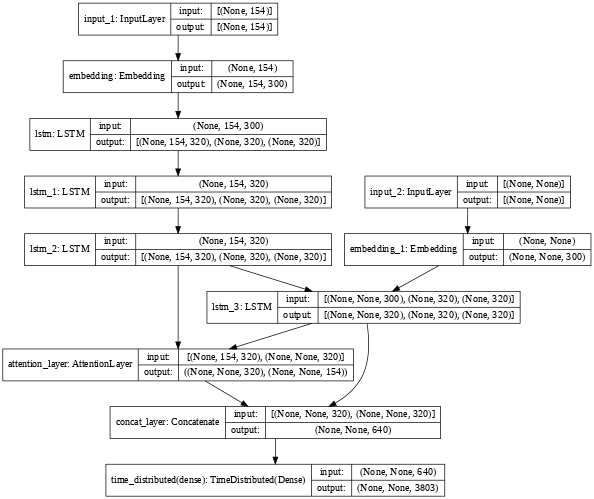

In [ ]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 154)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 154, 300)     4243200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 154, 320), ( 794880      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Entrenamiento

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [ ]:
%%time

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 20, 

                    #terminar antes cuando no disminuya la función de pérdida
                    #callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                    #                         verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/20
15/15 [==============================] - 481s 31s/step - loss: 3.6903 - val_loss: 2.5400
Epoch 2/20
15/15 [==============================] - 454s 30s/step - loss: 2.5183 - val_loss: 2.5655
Epoch 3/20
15/15 [==============================] - 452s 30s/step - loss: 2.4323 - val_loss: 2.3966
Epoch 4/20
15/15 [==============================] - 448s 30s/step - loss: 2.3242 - val_loss: 2.4030
Epoch 5/20
15/15 [==============================] - 456s 30s/step - loss: 2.2585 - val_loss: 2.2917
Epoch 6/20
15/15 [==============================] - 453s 30s/step - loss: 2.2095 - val_loss: 2.2815
Epoch 7/20
15/15 [==============================] - 454s 30s/step - loss: 2.1677 - val_loss: 2.2516
Epoch 8/20
15/15 [==============================] - 451s 30s/step - loss: 2.1289 - val_loss: 2.2420
Epoch 9/20
15/15 [==============================] - 453s 30s/step - loss: 2.1026 - val_loss: 2.2364
Epoch 10/20
15/15 [==============================] - 454s 30s/step - loss: 2.0764 - val_loss: 2.2287

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
# Guardar todo el modelo
model.save('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v_oct21')

In [ ]:
#modelo = tf.keras.models.load_model('/content/drive/MyDrive/Modelos/rrn_modelo_w2v')

# Check its architecture
#modelo.summary()

#Modelo de Inferencia y Generación de Texto

In [ ]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_textos), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

In [ ]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

# Implementación del modelo de inferencia mediante decode_sequence()

[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [ ]:
for i in range(10, 20):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

In [ ]:
len(range(len(x_test[0:200])))

In [ ]:
%%time
Review = pd.Series(np.apply_along_axis(seq2text, 1, x_test_seq[:50]), name='Review')
Original_summary = pd.Series(np.apply_along_axis(seq2summary, 1, y_test_seq[:50]), name = 'Original_Summary')

Predicted_summary = pd.Series(name = 'Predicted_summary').reindex_like(Review)
for i in range(50):
  Predicted_summary[i] = crea_resumen(x_test_seq[i].reshape(1, -1))
Predicted_summary

In [ ]:
Resultados = pd.concat([Review, Original_summary, Predicted_summary], axis=1)

Para guardar la tabla de resultados en un archivo, descomentar la siguiente linea, y reemplazar la ruta con la corresponeiente a la carpeta personal en el drive donde se quiera guardar.

In [ ]:
Resultados.to_csv('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/Resultados/resultados_rnn_oct21.csv', index=False)

In [ ]:
Resultados

# Evaluación con Rouge

Para leer los resultados desde el archivo csv guardado en drive en la sección anterior

In [ ]:
#Resultados = pd.read_csv('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/Resultados/resultados_rnn.csv')

In [ ]:
Resultados

In [ ]:
rouge = Rouge()

Se proporcionan resultados para dos tipos de métricas:
- ***rouge-n*** , evalúa los resultados usando n-gramas
- ***rouge-l***, evalúa en base a la secuencia más larga entre la referencia y el modelo

Además en cada tipo de métrica, se ealuá el modelo usando:
- $presición = \frac{n-gramas_{comunes} }{ n-gramas_{predicción}}$


- $recall = \frac{n-gramas_{comunes} }{ n-gramas_{referencia}}$

- $f1_{score} = 2*\frac{precision*recall }{precision+recall}$

In [ ]:
model_out = Resultados['Predicted_summary']
reference = Resultados['Original_summary']

rouge.get_scores(model_out, reference)[0:5]

In [ ]:
index = 43

print('Referencia: ', reference[index])
print('Resumen modelo:', model_out[index],'\n')

print('Precisión: ', rouge.get_scores(model_out, reference)[index]['rouge-1']['p'])
print('Recall: ', rouge.get_scores(model_out, reference)[index]['rouge-1']['r'])
print('F1 score: ', rouge.get_scores(model_out, reference)[index]['rouge-1']['f'])

In [ ]:
metrica = 'rouge-1'   # rouge-2  rouge-l

evaluacion_dict = {index: i[metrica]for index, i in zip(range(len(Resultados)), rouge.get_scores(model_out, reference))}
evaluation_df = pd.DataFrame.from_dict(evaluacion_dict, orient='index')
Resultados = pd.concat([Resultados, evaluation_df],axis=1)

In [ ]:
Resultados.sort_values(by=['r'], ascending=False)

ROUGE tiene la limitante de que es una evaluación sintáctica pero no semántica